# **K-Means Clustering**
Customer Segmentation based on Revenue they Generated (*MonetaryValue*), Frequency of Visits (*Frequency*), and Time since last Visit (*Recency*)

---

With the main portion of Analysis, Statistical Testing, and Time Series Analysis & Forecasting for developing the ***Dynamic Pricing Model*** complete, this Notebook will focus on another form of business optimization: by targeting potential consumers with ameliorated selling strategies through customer segmentation.



---


Credit for guidance completely goes to: https://www.youtube.com/@trentdoesmath | Trent Park

You should definitely check out his incredible work!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/final_df.csv').drop('Unnamed: 0', axis = 1) # "CPI" (Consumer Price Index) of 211.1, for example, Indicates that, on Average, Overall Product Prices have Increased by 111.1% since the Base Year

df.columns = df.columns.str.replace('_', '')

df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = df[['MarkDown1',
                                                                              'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

# Using "errors = 'coerce'"" to handle potential parsing errors by setting invalid dates to NaT (Not a Time)
# Using "format = 'mixed'"" to allow Pandas to infer the Date Format for each entry
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce') # Ensuring Proper Formatting for Dates

df['StoreSizeCategory'] = pd.Categorical(df['StoreSizeCategory'],
                                        categories = ['Small', 'Mid-Size', 'Above Average Size', 'Large', 'Super Store'],
                                        ordered = True) # Ensuring Proper Formatting for Store Size Categories

df.head(8)

,Store,Date,Temperature,FuelPrice,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,WeeklySales,Type,Size,StoreSizeCategory,Month,Day of Month,Year
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,A,151315,Above Average Size,Feb,5,2010
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,A,151315,Above Average Size,Feb,5,2010
2,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,A,151315,Above Average Size,Feb,5,2010
3,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,A,151315,Above Average Size,Feb,5,2010
4,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,A,151315,Above Average Size,Feb,5,2010
5,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,6,5749.03,A,151315,Above Average Size,Feb,5,2010
6,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,7,21084.08,A,151315,Above Average Size,Feb,5,2010
7,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,8,40129.01,A,151315,Above Average Size,Feb,5,2010


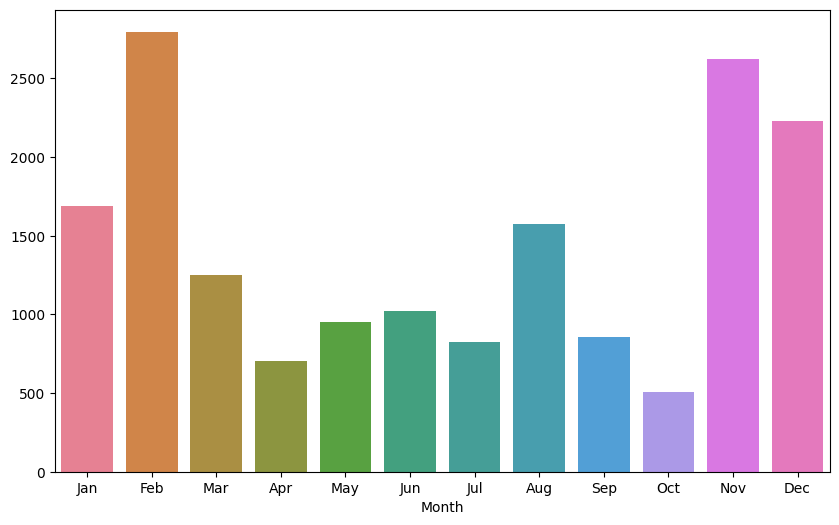

In [ ]:
# "Discount" Calculation
df['Discount'] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean(axis = 1).round(2) # "axis = 1" -> Across the Columns for each Row

df['Month'] = pd.Categorical(df['Month'], categories = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                             ordered = True)

plt.figure(figsize = (10, 6))
sns.barplot(x = df.groupby('Month')['Discount'].mean().index, y = df.groupby('Month')['Discount'].mean().values,
            hue = df.groupby('Month')['Discount'].mean().index)
plt.show()

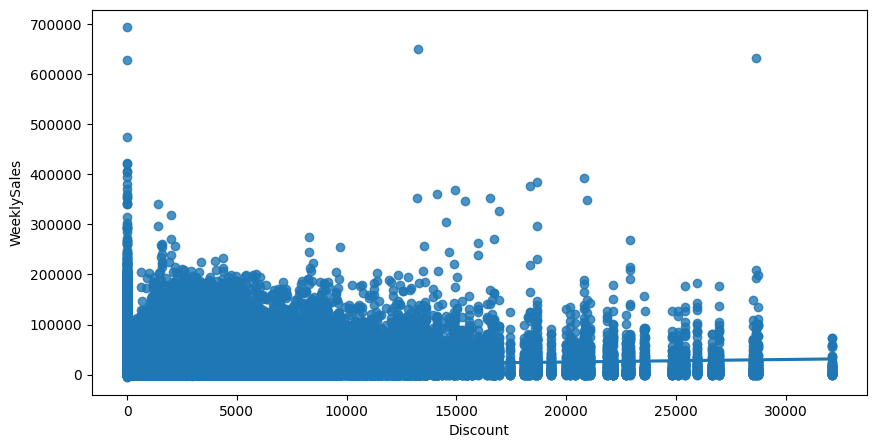

In [ ]:
# Let's Investigate the Relationship between Discount ($) and Weekly Sales ($)

plt.figure(figsize = (10, 5))
sns.regplot(x = df['Discount'], y = df['WeeklySales'])
plt.show()

count    421570.000000
mean       1336.808281
std        2950.188275
min           0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           0.000000
60%           0.000000
70%         804.080000
80%        2328.070000
90%        4150.240000
100%      32102.120000
max       32102.120000


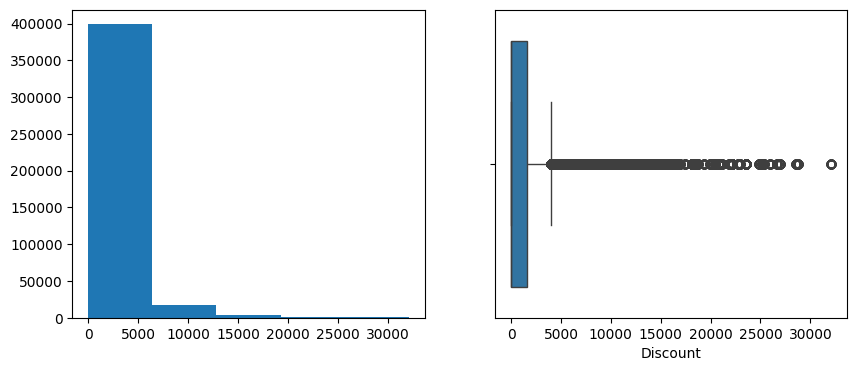

In [ ]:
# Looking into the "Discount" Column to Understand how to Categorize it Properly

plt.figure(figsize = (10, 4))

print(df['Discount'].describe(percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).to_string())

plt.subplot(1, 2, 1)
plt.hist(df['Discount'], bins = 5)

plt.subplot(1, 2, 2)
sns.boxplot(df['Discount'], orient = 'h')

plt.show()

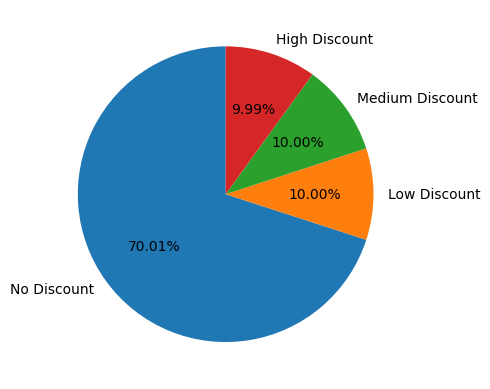

In [ ]:
# That^ gave me a good Sense of the Distribution of "Discount"s Applied - Will Categorize Accordingly & Then Move on to Clustering (K-Means)

plt.pie(pd.cut(df['Discount'], bins = [0, df['Discount'].quantile(0.6), df['Discount'].quantile(0.7), df['Discount'].quantile(0.8),
                               df['Discount'].quantile(0.9), df['Discount'].max()],
       labels = ['No Discount', 'Low Discount', 'Medium Discount', 'High Discount'], duplicates = 'drop',
        include_lowest = True).value_counts(normalize = True), labels = ['No Discount', 'Low Discount', 'Medium Discount', 'High Discount'],
        autopct = '%.2f%%', startangle = 90)
plt.show()

In [ ]:
df['DiscountCategory'] = pd.cut(df['Discount'], bins = [0, df['Discount'].quantile(0.6),
                                                        df['Discount'].quantile(0.7), df['Discount'].quantile(0.8),
                                                        df['Discount'].quantile(0.9), df['Discount'].max()],
                                                labels = ['No Discount', 'Low Discount', 'Medium Discount', 'High Discount'],
                                                duplicates = 'drop',
                                                include_lowest = True)

In [ ]:
# POSSIBLE Preprocessing: Preparing the Data with Dummy Variables for Multiple Linear Regression

# df = df.join(pd.get_dummies(df['DiscountCategory'], prefix = 'DiscountApplied_').astype(int)).drop('DiscountCategory', axis = 1)
# df.head(5)

### **Feature Engineering**

In [ ]:
# Daily Sales in each Store for the Day, for that Specific Department

df['DailySales'] = (df['WeeklySales']/7).round(2).astype(float)
df.head(6)

,Store,Date,Temperature,FuelPrice,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,WeeklySales,Type,Size,StoreSizeCategory,Month,Day of Month,Year,Discount,DiscountCategory,DailySales
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,A,151315,Above Average Size,Feb,5,2010,0.0,No Discount,3560.64
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,A,151315,Above Average Size,Feb,5,2010,0.0,No Discount,7229.32
2,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,A,151315,Above Average Size,Feb,5,2010,0.0,No Discount,1962.87
3,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,A,151315,Above Average Size,Feb,5,2010,0.0,No Discount,5707.72
4,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,A,151315,Above Average Size,Feb,5,2010,0.0,No Discount,4604.20
5,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,6,5749.03,A,151315,Above Average Size,Feb,5,2010,0.0,No Discount,821.29


In [ ]:
# CRUCIAL!
# Creating a Unique Identifier for each Transaction based on Store, Department, and Date

df['DiscountCode'] = df['DiscountCategory'].map({'No Discount': 0, 'Low Discount': 1, 'Medium Discount': 2, 'High Discount': 3})

df['TransactionID'] = (df['Store'].astype(str) + df['Dept'].astype(str) + df['DiscountCode'].astype(str))

display(df[['Store', 'Dept', 'Date', 'TransactionID']].head())

,Store,Dept,Date,TransactionID
0,1,1,2010-02-05,110
1,1,2,2010-02-05,120
2,1,3,2010-02-05,130
3,1,4,2010-02-05,140
4,1,5,2010-02-05,150


In [ ]:
# Analyzing Customer Behavior
# Let's Aggregate our Data by Transaction ID
# Then, will Compute the Aggregates for the Recency, Frequency, and Monetary Value

df_alt = df[df['Discount'] != 0]
df_alt['Date'] = pd.to_datetime(df_alt['Date'], format = '%d/%m/%Y')

#
agg_df = df_alt.groupby('TransactionID', as_index = False) \
    .agg(
      MonetaryValue = ('DailySales', 'sum'), # Total Money Spent by each TransactionID
      Frequency = ('TransactionID', 'count'), # Frequency of Expenditure by each TransactionID
      LastSpentDate = ('Date', 'max') # Latest Recording of Expenditure for each Transaction ID
    )

agg_df.sample(7)

,TransactionID,MonetaryValue,Frequency,LastSpentDate
8680,6121,10925.31,12,2012-10-26
1584,16203,1317.54,3,2012-02-10
2313,18581,6754.98,13,2012-10-26
3961,24871,39596.97,10,2012-10-19
4491,27193,5472.02,25,2012-10-05
9705,9823,2766.99,2,2012-02-03
4630,27773,116.96,3,2012-03-02


In [ ]:
# Will Base Recency off of the Last Date of Expenditure^

agg_df['Recency'] = (agg_df['LastSpentDate'].max() - agg_df['LastSpentDate']).dt.days

agg_df

,TransactionID,MonetaryValue,Frequency,LastSpentDate,Recency
0,10101,70547.35,10,2012-10-19,7
1,10102,111600.97,16,2012-10-26,0
2,10103,172222.10,25,2012-10-05,21
3,1011,70564.90,10,2012-10-19,7
4,10111,48138.51,10,2012-10-19,7
...,...,...,...,...,...
9742,9963,1182.83,2,2012-02-03,266
9743,9980,3.50,2,2012-01-27,273
9744,9981,26.47,5,2012-05-18,161
9745,9982,10.89,2,2012-01-06,294


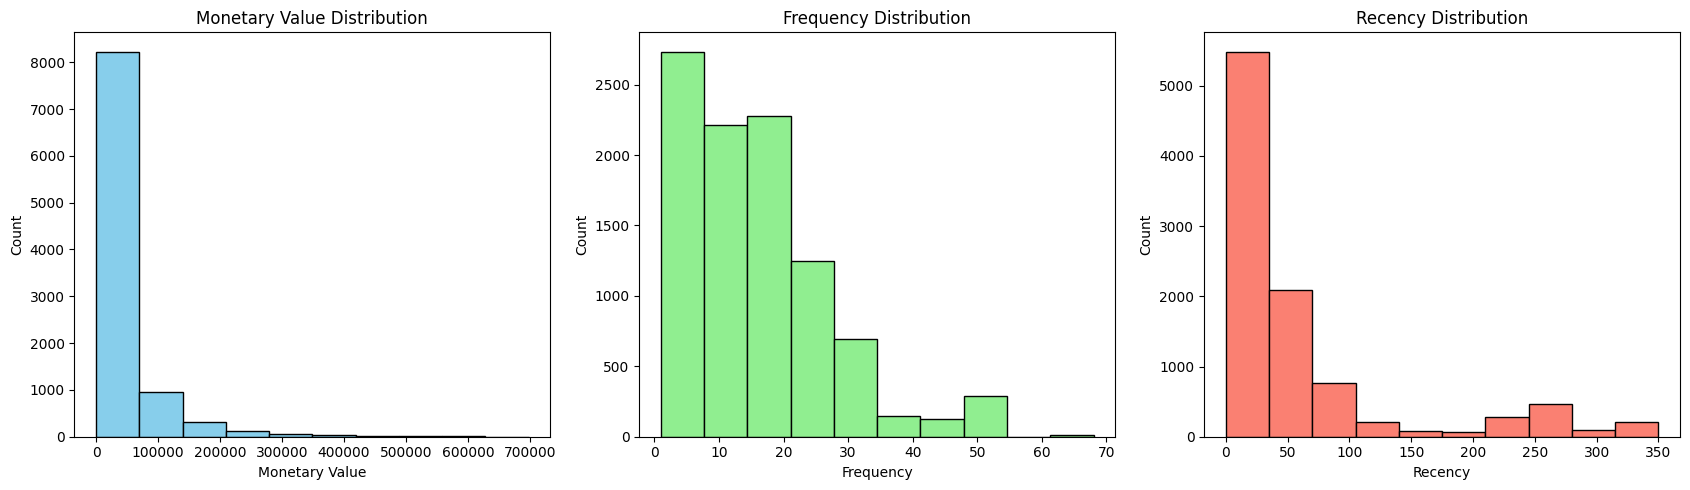

In [ ]:
# Outliers can Badly Influence the Clustering Algorithm
# So, we will look at our Aggregated Distributions

plt.figure(figsize = (17, 5))

plt.subplot(1, 3, 1)
plt.hist(agg_df['MonetaryValue'], bins = 10, color = 'skyblue', edgecolor = 'black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(agg_df['Frequency'], bins = 10, color = 'lightgreen', edgecolor = 'black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(agg_df['Recency'], bins = 10, color = 'salmon', edgecolor = 'black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

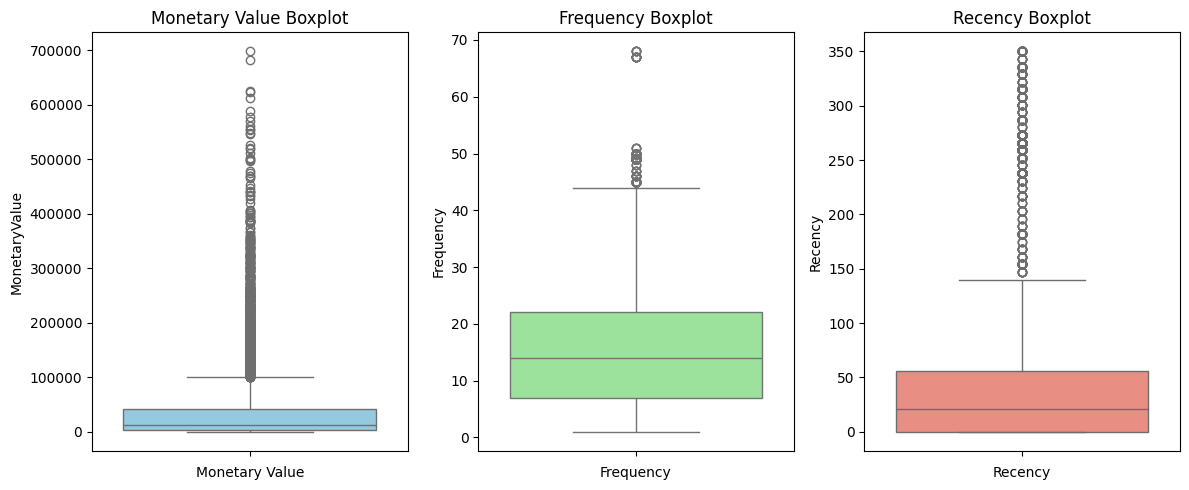

In [ ]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 3, 1)
sns.boxplot(agg_df['MonetaryValue'], color = 'skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(agg_df['Frequency'], color = 'lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(agg_df['Recency'], color = 'salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

# Seriously need to Deal with Outliers for Monetary Value and Recency
# However, the Outliers in "Monetary Value" are Actually the Customers who have Spent the most - i.e., the most Valuable Customers
# So, will Avoid Outlier Removal; instead, will "Separate out" the Outliers for a Separate Analysis/Categorization and use Remaining Data for K-Means Clustering

In [ ]:
# Interquartile Range to Get Outliers (Temporarily) Removed: for "Monetary Value" and "Recency"
# "Frequency" Does NOT need Outlier Dealing (as much)


# Monetary Values
m_q1 = agg_df['MonetaryValue'].quantile(0.25)
m_q3 = agg_df['MonetaryValue'].quantile(0.75)
m_iqr = m_q3 - m_q1

mon_outliers_df = agg_df[((agg_df['MonetaryValue'] > (m_q3 + 1.5*m_iqr)) | (agg_df['MonetaryValue'] < (m_q1 - 1.5*m_iqr)))].copy()

# Recency Values
r_q1 = agg_df['Recency'].quantile(0.25)
r_q3 = agg_df['Recency'].quantile(0.75)
r_iqr = r_q3 - r_q1

rec_outliers_df = agg_df[((agg_df['Recency'] > (r_q3 + 1.5*r_iqr)) | (agg_df['Recency'] < (r_q1 - 1.5*r_iqr)))].copy()

display(mon_outliers_df.describe())
print('')
display(rec_outliers_df.describe())

,MonetaryValue,Frequency,LastSpentDate,Recency
count,993.000000,993.00000,993,993.000000
mean,184505.545307,26.12286,2012-10-05 03:33:10.332326144,20.851964
min,99915.530000,6.00000,2012-08-03 00:00:00,0.000000
25%,120602.960000,19.00000,2012-09-21 00:00:00,0.000000
50%,151391.510000,23.00000,2012-10-05 00:00:00,21.000000
75%,211351.810000,32.00000,2012-10-26 00:00:00,35.000000
max,698077.480000,68.00000,2012-10-26 00:00:00,84.000000
std,94166.268716,11.00710,NaN,20.623283


,MonetaryValue,Frequency,LastSpentDate,Recency
count,1184.000000,1184.000000,1184,1184.000000
mean,3300.928395,2.646115,2012-02-08 15:47:25.945945856,260.342061
min,-235.000000,1.000000,2011-11-11 00:00:00,147.000000
25%,22.710000,1.000000,2012-01-13 00:00:00,238.000000
50%,459.515000,2.000000,2012-02-10 00:00:00,259.000000
75%,2938.335000,3.000000,2012-03-02 00:00:00,287.000000
max,98138.200000,14.000000,2012-06-01 00:00:00,350.000000
std,8491.554102,2.498135,NaN,46.092289


In [ ]:
# DataFrame without Outliers

non_outliers_df = agg_df[(~agg_df.index.isin(mon_outliers_df.index)) & (~agg_df.index.isin(rec_outliers_df.index))]

non_outliers_df.describe().round(2)

,MonetaryValue,Frequency,LastSpentDate,Recency
count,7570.00,7570.00,7570,7570.00
mean,21510.88,16.16,2012-09-29 10:39:54.927344640,26.56
min,-120.40,1.00,2012-06-08 00:00:00,0.00
25%,3176.04,9.00,2012-09-14 00:00:00,0.00
50%,11803.08,15.00,2012-10-12 00:00:00,14.00
75%,32283.38,22.00,2012-10-26 00:00:00,42.00
max,99729.24,68.00,2012-10-26 00:00:00,140.00
std,24107.40,10.45,NaN,30.89


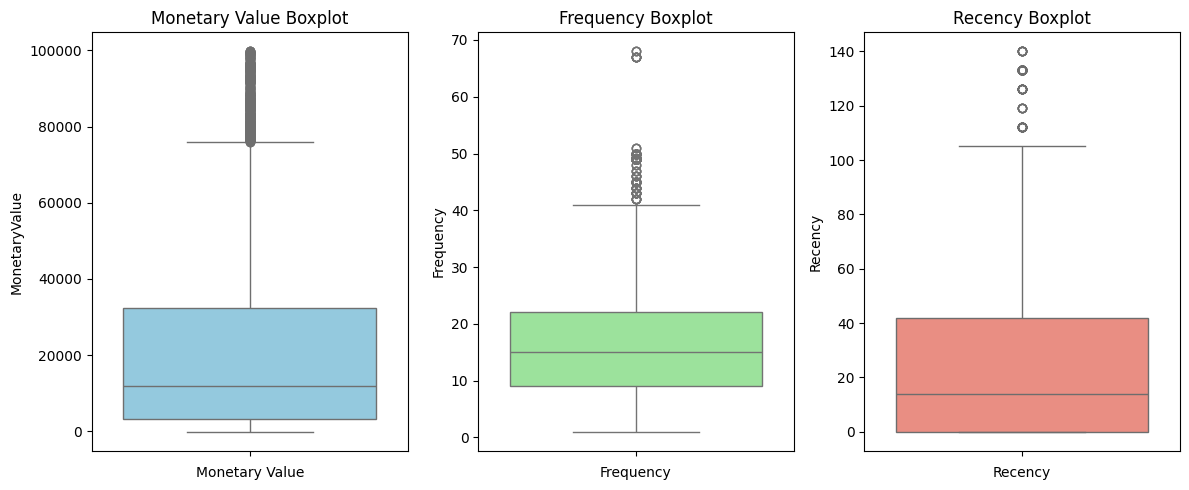

In [ ]:
# Now, Let's Check out the Distributions!

plt.figure(figsize = (12, 5))

plt.subplot(1, 3, 1)
sns.boxplot(non_outliers_df['MonetaryValue'], color = 'skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(non_outliers_df['Frequency'], color = 'lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(non_outliers_df['Recency'], color = 'salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

### 3-D Visualization!

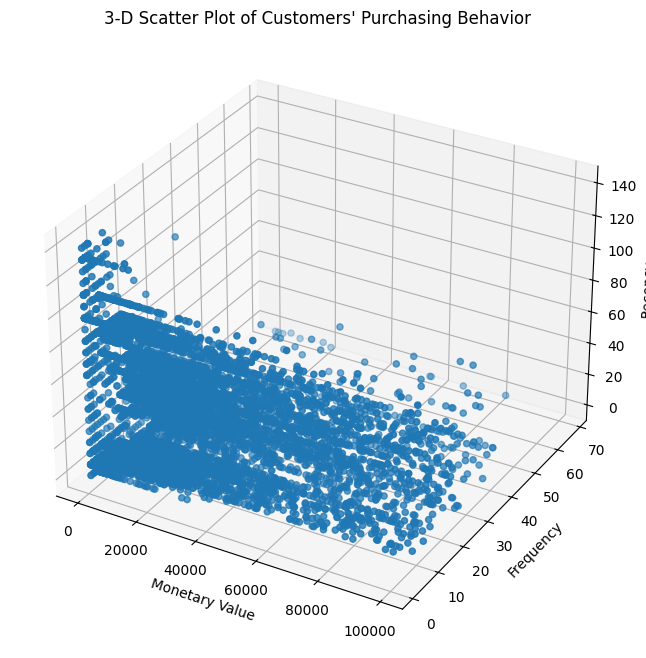

In [ ]:
fig = plt.figure(figsize = (9, 8))

ax = fig.add_subplot(projection = '3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], non_outliers_df['Frequency'], non_outliers_df['Recency'])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title("3-D Scatter Plot of Customers' Purchasing Behavior")

plt.show()

### Standard-Scaling:

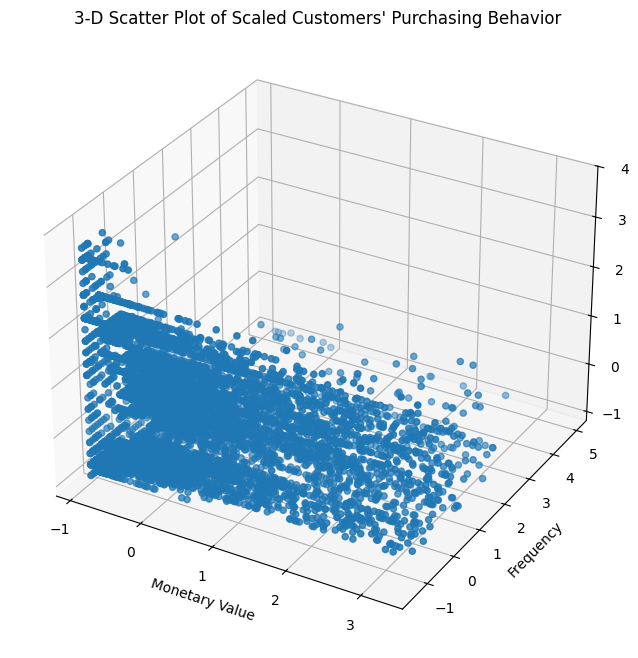

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

scaled_df = sc.fit_transform(non_outliers_df[['MonetaryValue', 'Frequency', 'Recency']])

# Converting the Array back into a DataFrame
scaled_df = pd.DataFrame(scaled_df, index = non_outliers_df.index, columns = ['MonetaryValue', 'Frequency', 'Recency'])

# Let's Now Plot with the Scaled Data

fig = plt.figure(figsize = (9, 8))

ax = fig.add_subplot(projection = '3d')

scatter = ax.scatter(scaled_df['MonetaryValue'], scaled_df['Frequency'], scaled_df['Recency'])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title("3-D Scatter Plot of Scaled Customers' Purchasing Behavior")

plt.show() # The Point Locations have NOT Changed; but the Scales have and that is Perfect

# **K-Means Clustering**

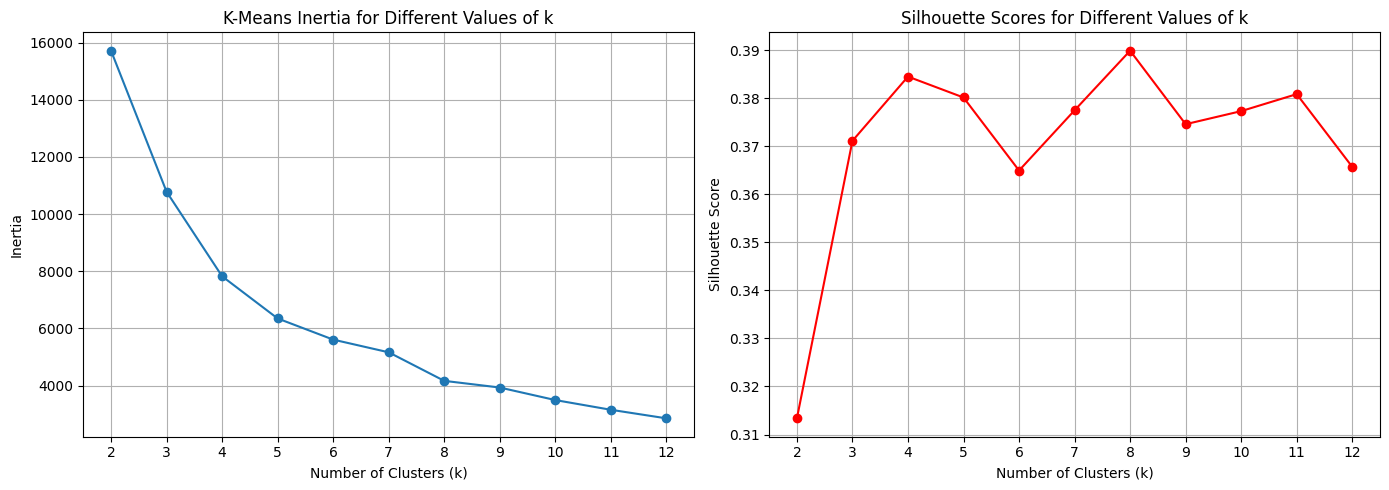

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_k = 12

inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
  kmeans = KMeans(n_clusters = k, random_state = 30, max_iter = 10000)
  cluster_labels = kmeans.fit_predict(scaled_df)
  sil_score = silhouette_score(scaled_df, cluster_labels)
  silhouette_scores.append(sil_score)
  inertia.append(kmeans.inertia_)

plt.figure(figsize = (14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker = 'o', linestyle = '-')
plt.title('K-Means Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker = 'o', linestyle = '-', color = 'red')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show() # 5 Clusters appear Optimal; also have a Higher Silhouette Score than 4 and a Bigger Decline in Inertia

In [ ]:
kmeans = KMeans(n_clusters = 5, random_state = 30, max_iter = 10000)

cluster_labels = kmeans.fit_predict(scaled_df)

In [ ]:
non_outliers_df['Cluster no.'] = cluster_labels + 1
non_outliers_df.head(6)

,TransactionID,MonetaryValue,Frequency,LastSpentDate,Recency,Cluster no.
0,10101,70547.35,10,2012-10-19,7,4
3,1011,70564.90,10,2012-10-19,7,4
4,10111,48138.51,10,2012-10-19,7,4
5,10112,72465.93,16,2012-10-26,0,4
7,1012,71724.15,16,2012-10-26,0,4
8,10121,12632.87,10,2012-10-19,7,2


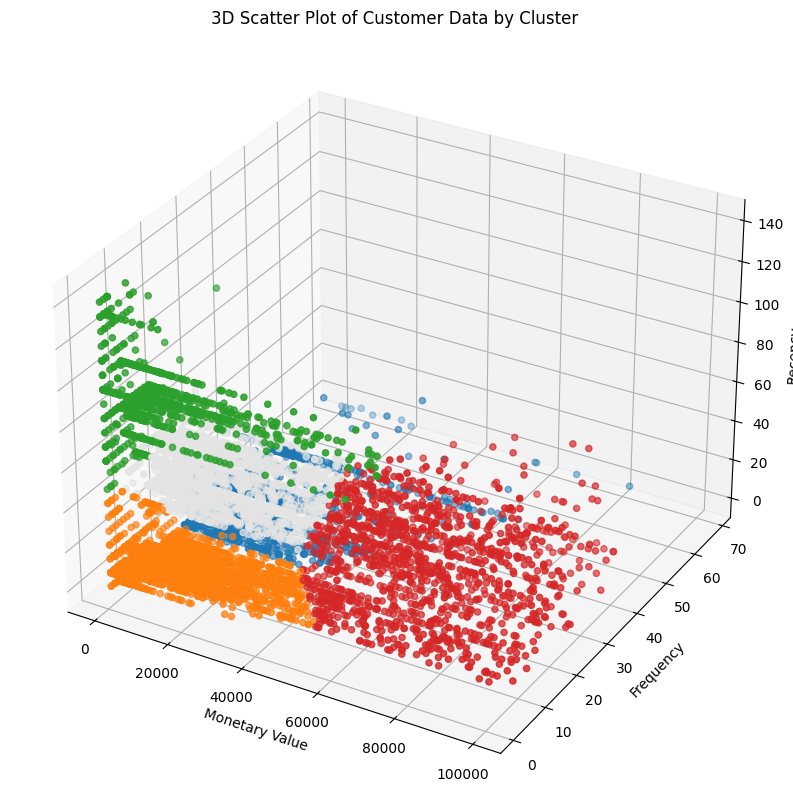

In [ ]:
# 3-D Visualization of the K-Means Clusters

cluster_colors = {1: '#1f77b4',  # Blue
                  2: '#ff7f0e',  # Orange
                  3: '#2ca02c',  # Green
                  4: '#d62728',  # Red
                  5: '#e4e4e4'}  # Light Gray

colors = non_outliers_df['Cluster no.'].map(cluster_colors)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = '3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'],
                     non_outliers_df['Frequency'],
                     non_outliers_df['Recency'],
                     c = colors,  # Using Mapped Solid Colors
                     marker = 'o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

## Cluster Analysis

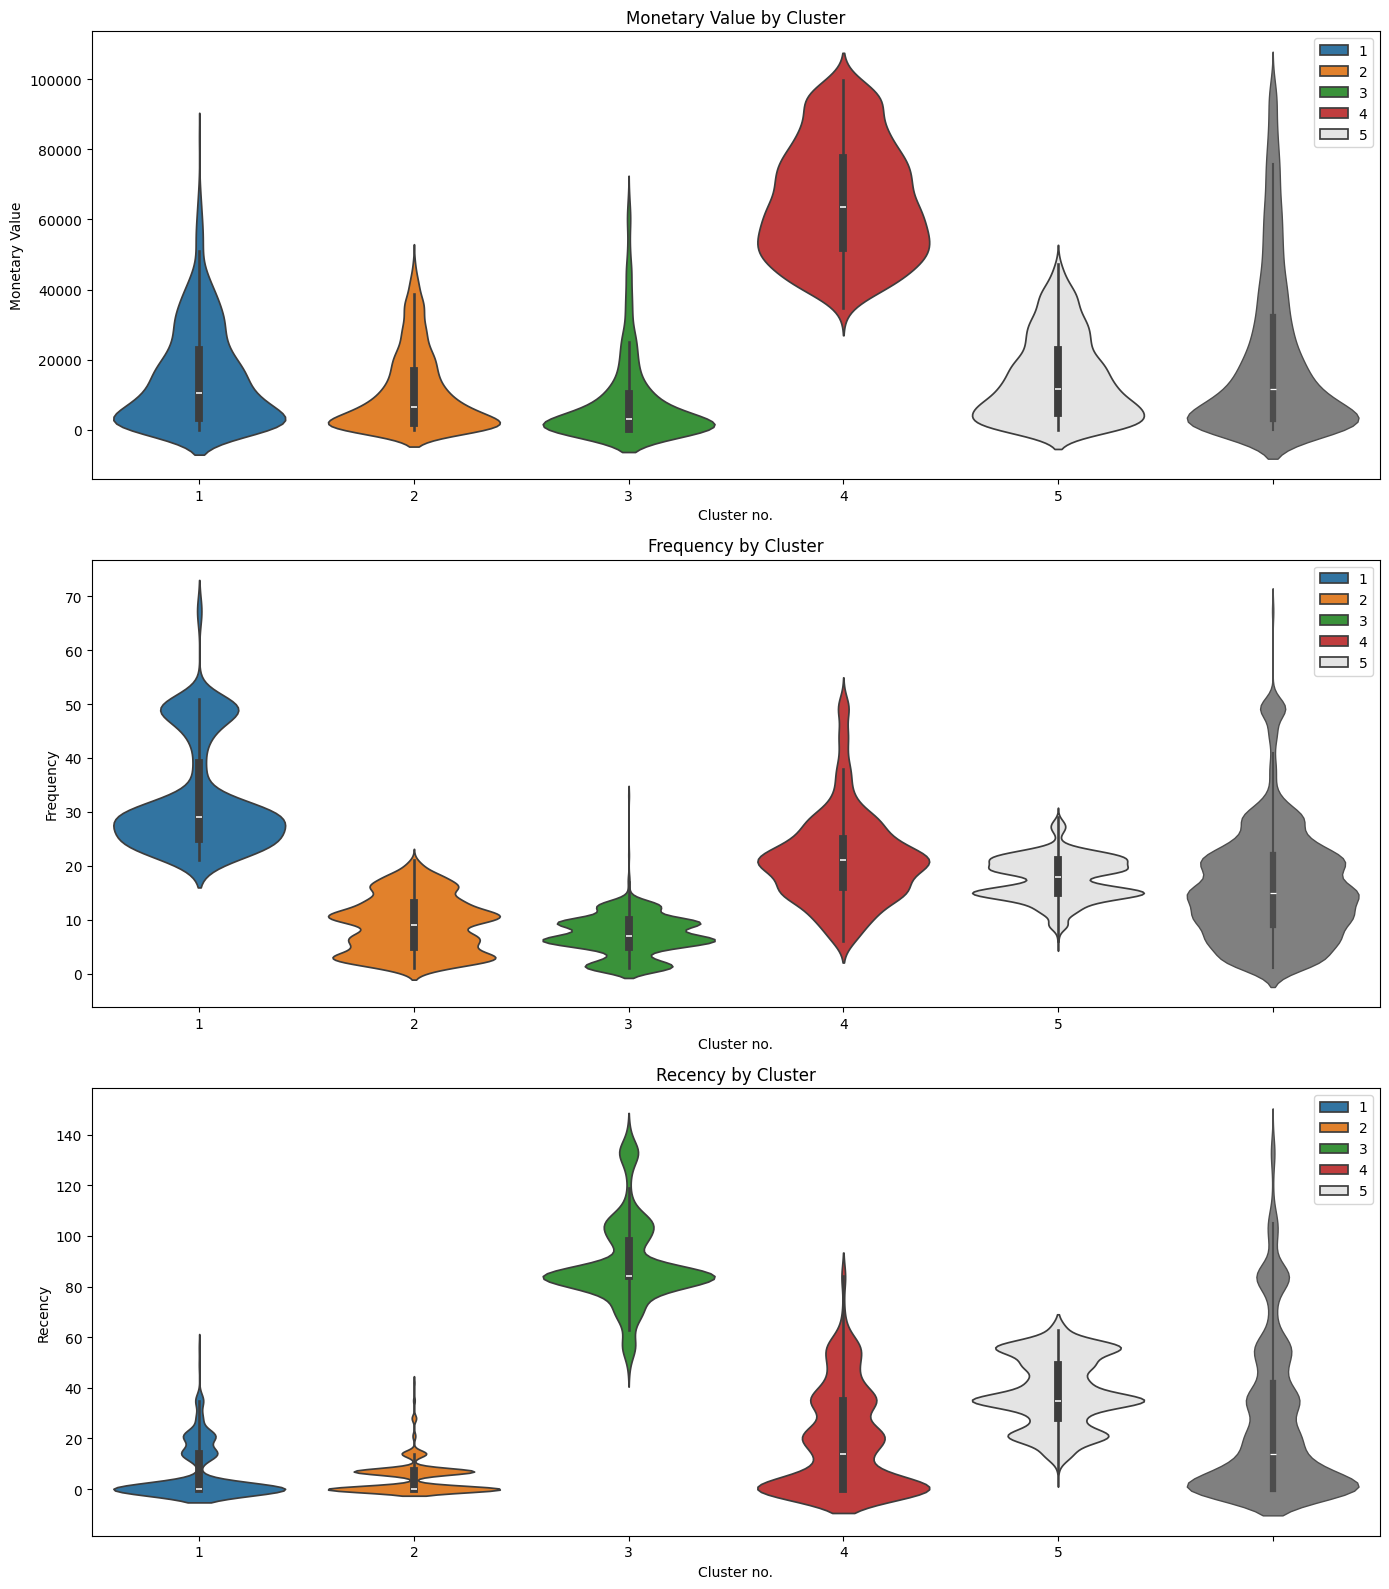

In [ ]:
# Violin Plots to look more Deeply into Various Distributions of the Features

plt.figure(figsize = (14, 16))

plt.subplot(3, 1, 1)
sns.violinplot(x = non_outliers_df['Cluster no.'], y = non_outliers_df['MonetaryValue'], palette = cluster_colors, hue = non_outliers_df['Cluster no.'])
sns.violinplot(y = non_outliers_df['MonetaryValue'], color = 'gray', linewidth = 1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x = non_outliers_df['Cluster no.'], y = non_outliers_df['Frequency'], palette = cluster_colors, hue = non_outliers_df['Cluster no.'])
sns.violinplot(y = non_outliers_df['Frequency'], color = 'gray', linewidth = 1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x = non_outliers_df['Cluster no.'], y = non_outliers_df['Recency'], palette = cluster_colors, hue = non_outliers_df['Cluster no.'])
sns.violinplot(y = non_outliers_df['Recency'], color = 'gray', linewidth = 1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.savefig('ViolinPlots_KMeansClusters.png')
plt.show()

## Cluster Analysis Findings & Business Interpretations:

* Cluster 1: Retain
* Cluster 2: Re-Engage
* Cluster 3: Re-Engage More Strongly
* Cluster 4: Reward
* Cluster 5: Re-Engage More Strongly

Cluster 1: Generate Average revenue, but shop the most regularly, as indicated by their Very Low recency and High frequency.
Should value them and keep them engaged to the business with periodic discount vouchers and promotional events.

Clusters 3 and 5: Very High recency measures (i.e., purchased only periodically), Low or Average-with-concentration-on-lower-end frequency of purchases, and Very Low revenue generated.
Need to re-engage these customers back into the business with better marketing strategies and purchase incentives.

Cluster 2: Very similar to clusters 3 and 5 but with the better giveaway of Lower recency.
Need to re-engage these customers and give them incentives to spend more.

Cluster 4: High recency, Medium frequency, and Highest revenue generated. Clearly the group most profitable to the business.
Must value them as prime clients of the retail industry, and keep-by-rewarding them with regular discounts and incentives, etc.


^**This K-Means Clustering & Cluster Analysis helps us to learn about Customer Behavior, through Measuring Expenditures on Products in Stores, and can definitely inform our future Pricing Strategy indirectly.**

## Outlier Analysis: (NOT as Important in this Case, but will be kept for Reference)

In [ ]:
overlap_indices = mon_outliers_df.index.intersection(rec_outliers_df.index) # Addressing any Overlap

monetary_only_outliers = mon_outliers_df.drop(overlap_indices)
recency_only_outliers = rec_outliers_df.drop(overlap_indices)

mon_and_rec_outliers = mon_outliers_df.loc[overlap_indices]

# Manually Assigning Cluster Labels
monetary_only_outliers['Cluster no.'] = -1
recency_only_outliers['Cluster no.'] = -2
mon_and_rec_outliers['Cluster no.'] = -3

# Going to Union all Outliers' Clusters
outlier_clusters_df = pd.concat([monetary_only_outliers, recency_only_outliers, mon_and_rec_outliers])

outlier_clusters_df['Cluster no.'].value_counts()

In [ ]:
# Violin Plots to look more Deeply into Various Distributions of the Outliers

cluster_colors = {-1: '#1f77b4',  # Blue
                  -2: '#ff7f0e',  # Orange
                  -3: '#2ca02c'}  # Green

plt.figure(figsize = (14, 20))

plt.subplot(3, 1, 1)
sns.violinplot(x = outlier_clusters_df['Cluster no.'], y = outlier_clusters_df['MonetaryValue'], palette = cluster_colors, hue = outlier_clusters_df['Cluster no.'])
sns.violinplot(y = outlier_clusters_df['MonetaryValue'], color = 'gray', linewidth = 1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x = outlier_clusters_df['Cluster no.'], y = outlier_clusters_df['Frequency'], palette = cluster_colors, hue = outlier_clusters_df['Cluster no.'])
sns.violinplot(y = outlier_clusters_df['Frequency'], color = 'gray', linewidth = 1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x = outlier_clusters_df['Cluster no.'], y = outlier_clusters_df['Recency'], palette = cluster_colors, hue = outlier_clusters_df['Cluster no.'])
sns.violinplot(y = outlier_clusters_df['Recency'], color = 'gray', linewidth = 1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()